# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
    !mkdir tables

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from utils import decorate, savefig

## The World Cup problem

In the 2018 FIFA World Cup final, France defeated Croatia 4 goals to 2.  Based on this outcome:

1. How confident should we be that France is the better team?

2. If the same teams played again, what is the chance France would win again?

To answer these questions, we have to make some modeling decisions.

* First, I'll assume that for any team against any other team there is some unknown goal-scoring rate, measured in goals per game, which I'll denote `λ`.

* Second, I'll assume that a goal is equally likely during any minute of a game.  So, in a 90 minute game, the probability of scoring during any minute is `λ/90`.

* Third, I'll assume that a team never scores twice during the same minute.

Of course, none of these assumptions is absolutely true in the real world, but I think they are reasonable simplifications.

As George Box said, "[All models are wrong; some are useful.](https://en.wikipedia.org/wiki/All_models_are_wrong)"

## The Poisson distribution

Under these assumptions, the number of goals scored in a game follows a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution).  If we know that the goal-scoring rate is $\lambda$, the probability of scoring $k$ goals is

$f(k; \lambda) = \lambda^k \exp(-\lambda) ~/~ k!$

SciPy provides a function that computes this expression; we can use it like this:

In [4]:
from scipy.stats import poisson

def make_poisson_pmf(λ, high):
    """Make a PMF of a Poisson distribution.
    
    λ: event rate
    high: upper bound on number of events, `k`
    
    returns: Pmf of number of events
    """
    qs = np.arange(high)
    ps = poisson.pmf(qs, λ)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [5]:
pmf_goals = make_poisson_pmf(λ=1.4, high=10)

The following figure compares these values with the results we got by simulation.

In [6]:
def decorate_goals(title=''):
    decorate(xlabel='Number of goals',
        ylabel='PMF',
        title=title)

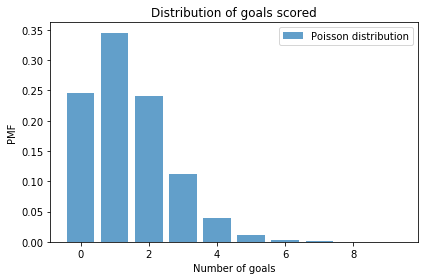

In [7]:
pmf_goals.bar(alpha=0.7, label='Poisson distribution')

decorate_goals('Distribution of goals scored')
savefig('fig07-01')

Now let's turn it around: given the number of goals scored in a game, how can we estimate `λ`?

First, we need a prior distribution for `λ`, which represents the range of possible values and their probabilities before we see the score.

Then we use the data to update the distribution.  

The result is a posterior distribution that represents our estimate of `λ` after seeing the score.

## The prior

If you have ever seen a soccer game, you have some information about `λ`.  In most games, teams score a few goals each.  In rare cases, a team might score more than 5 goals, but they almost never score more than 10.

Using [data from previous World Cups](https://www.statista.com/statistics/269031/goals-scored-per-game-at-the-fifa-world-cup-since-1930/) I estimate that each team scores about 1.4 goals per game, on average.  So I'll set the mean of `λ` to be 1.4.

For a good team against a bad one, we expect `λ` to be higher; for a bad team against a good one, we expect it to be lower.

To model the distribution of goal-scoring rates, I will use a [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution), which I chose because:

1. The goal scoring rate is a continuous quantity that cannot be less than 0, and the gamma distribution is appropriate for this kind of quantity.

2. The gamma distribution has only one parameter, `α`, which is the mean.  So it's easy to construct a gamma distribution with the mean we want.

3. As we'll see, the shape of the Gamma distribution is a reasonable choice, given what we know about soccer.

We can use `scipy.stats.gamma` to compute the values of the gamma distribution, like this:

In [8]:
from scipy.stats import gamma

α = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma.pdf(qs, α)

The parameter, `α`, is the mean of the distribution.

`qs` is an array of possible values for `λ`, from 0 to 10.

`ps` is an array of probabilities, one for each value of `λ`.

Now we can use `qs` and `ps` to make a `Pmf` that represents the prior distribution.

In [9]:
prior = Pmf(ps, qs)
prior.normalize()
prior.mean()

1.4140818156118378

The prior mean is a little higher than 1.4; that's because we are approximating a continuous distribution with an array of discrete values.

But since the choice of prior is partly arbitrary, we don't have to be too precise.

Here's what it looks like.

In [11]:
def decorate_rate(title=''):
    decorate(xlabel='Goal scoring rate (λ)',
        ylabel='PMF',
        title=title)

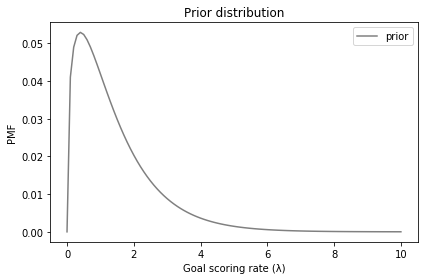

In [12]:
prior.plot(label='prior', color='gray')
decorate_rate('Prior distribution')
savefig('fig07-02')

This distribution represents our prior knowledge about goal scoring: `λ` is usually less than 2, occasionally as high as 6, and seldom higher than that.  And the mean is about 1.4.

As usual, reasonable people could disagree about the details of the prior. But this is good enough to get started.  Let's do an update.

## The update

Suppose you are given the goal-scoring rate, $λ$, and asked to compute the probability of scoring a number of goals, $k$.  That is precisely the question we answered by computing the Poisson distribution:

$ f(k; λ) = \lambda^k \exp(-\lambda) ~/~ k! $

For example, if $λ$ is 1.4, the probability of scoring 4 goals in a game is:

In [13]:
λ = 1.4
k = 4
poisson.pmf(4, λ)

0.039471954028253146

Now suppose we are have an array of possible values for λ, like this:

In [14]:
λs = prior.qs

We can compute the likelihood of the data for each hypothetical value of λ, like this:

In [15]:
k = 4
likelihood = poisson.pmf(k, λs)

And that's all we need to do the update.  

Here's the function we used in the previous notebook; it takes a prior distribution and an array of likelihoods, does a Bayesian update, and returns the total probability of the data.

In [16]:
def update_poisson(pmf, data):
    """Update the PMF with a Poisson likelihood
    
    pmf: Series that represents the prior
    data: integer number of goals
    
    returns: float probability of the data
    """
    k = data
    λs = pmf.qs
    likelihood = poisson.pmf(k, λs)
    pmf *= likelihood
    pmf.normalize()

In the example, France scored 4 goals, so I'll make a copy of the prior and update it with the data.

In [17]:
france = prior.copy()
update_poisson(france, 4)

Under the prior distribution, the probability of scoring 4 goals was about 5%.

Here's what the posterior distribution looks like:

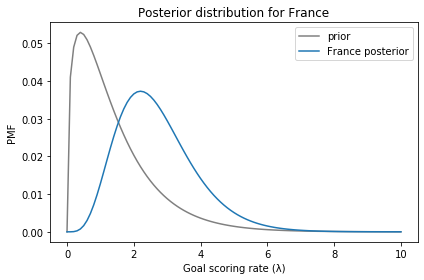

In [18]:
prior.plot(label='prior', color='gray')
france.plot(label='France posterior', color='C0')

decorate_rate('Posterior distribution for France')

The data, `k=4`, makes us think higher values of `λ` are more likely and lower values are less likely.  So the posterior distribution is shifted to the right.

Remember that the prior mean was about 1.4; here's the posterior mean:

In [19]:
prior.mean(), france.mean()

(1.4140818156118378, 2.699772393342308)

The posterior mean is near 2.7, which is between the prior (1.4) and the data (4).

Having seen 4 goals, we think France's goal-scoring rate is higher than 1.4, but we have not seen enough data to go all the way to 4.

Let's do the same for Croatia:

In [20]:
croatia = prior.copy()
update_poisson(croatia, 2)

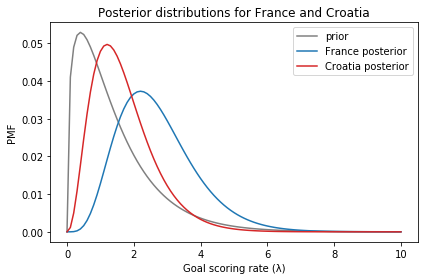

In [21]:
prior.plot(label='prior', color='gray')
france.plot(label='France posterior', color='C0')
croatia.plot(label='Croatia posterior', color='C3')

decorate_rate('Posterior distributions for France and Croatia')
savefig('fig07-03')

In [22]:
croatia.mean()

1.6999765866755225

### Probability of superiority

Now that we have a posterior distribution for each team, we can answer the first question: How confident should we be that France is the better team?

In the model, "better" means having a higher goal-scoring rate against the opponent.  We can use the posterior distributions to compute the probability that a random value drawn from France's distribution exceeds a value drawn from Croatia's.

One way to do that is to enumerate all pairs of values from the two distributions, adding up the total probability that one value exceeds the other.

In [23]:
def prob_gt(pmf1, pmf2):
    """Compute the probability of superiority.
    
    pmf1: Pmf object
    pmf2: Pmf object
    
    returns: float probability
    """
    total = 0
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            if q1 > q2:
                total += p1 * p2
    return total

Here's how we use it:

In [24]:
prob_gt(france, croatia)

0.7499366290930155

`Pmf` provides a function that does the same thing.

In [25]:
Pmf.prob_gt(france, croatia)

0.7499366290930174

On the basis of one game, we have moderate confidence that France is actually the better team.

### Predicting the rematch

Now we can take on the second question: If the same teams played again, what is the chance Croatia would win?

To answer this question, we'll generate the "posterior predictive distribution", which is the number of goals we expect a team to score.

If we knew the goal scoring rate, `λ`, the distribution of goals would be a Poisson distribution with parameter `λ`.

Since we don't know `λ`, the distribution of goals is a mixture of a Poisson distributions with different values of `λ`.

Here's a sequence of `Pmf` objects, one for each value of `λ`.

In [26]:
pmf_seq = [make_poisson_pmf(λ, 12) for λ in prior.qs]

And here's what they look like.

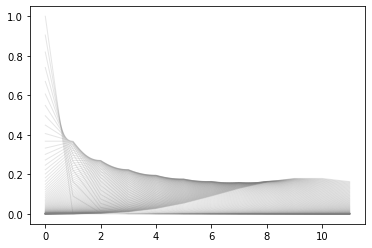

In [27]:
for pmf in pmf_seq:
    pmf.plot(color='gray', lw=1, alpha=0.2)

The predictive distribution is a mixture of these `Pmf`s, weighted with the posterior probabilities.

In [31]:
from utils import make_mixture

In [29]:
pred_france = make_mixture(france, pmf_seq)

Here's the predictive distribution for France.

2.6919056583999246

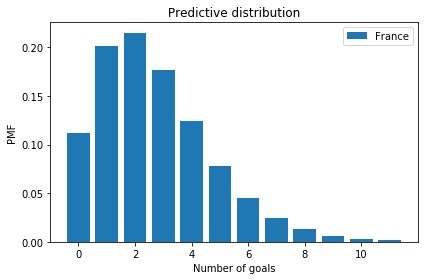

In [30]:
pred_france.bar(color='C0', label='France')
decorate_goals('Predictive distribution')
pred_france.mean()

This distribution represents two sources of uncertainty: we don't know the actual value of λ, and even if we did, we would not know the number of goals in the next game.

Here's the predictive distribution for Croatia.

In [32]:
pred_croatia = make_mixture(croatia, pmf_seq)

1.6989408917517321

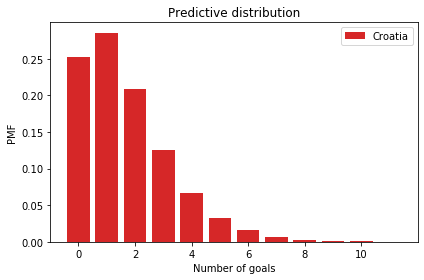

In [33]:
pred_croatia.bar(color='C3', label='Croatia')
decorate_goals('Predictive distribution')
pred_croatia.mean()

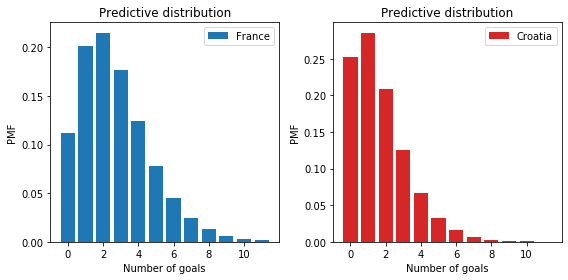

In [34]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
pred_france.bar(color='C0', label='France')
decorate_goals('Predictive distribution')

plt.subplot(1, 2, 2)
pred_croatia.bar(color='C3', label='Croatia')
decorate_goals('Predictive distribution')

savefig('fig07-04')

Now we can compute the fraction of rematches France would win, lose or tie.

In [35]:
win = Pmf.prob_gt(pred_france, pred_croatia)
win

0.5708850334650848

In [36]:
lose = Pmf.prob_lt(pred_france, pred_croatia)
lose

0.26429986403909056

In [37]:
tie = Pmf.prob_eq(pred_france, pred_croatia)
tie

0.16481510249582476

In [38]:
win + tie/2

0.6532925847129971

Assuming that France wins half of the ties, their chance of winning the rematch is about 65%.

## The Exponential Distribution

Here's a variation on the World Cup Problem:

>In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

In this version, notice that the data is not the number of goals in a fixed period of time, but the time between goals.

To compute the likelihood of data like this, we can take advantage of the theory of [Poisson processes](https://en.wikipedia.org/wiki/Poisson_point_process).  In our model of a soccer game, we assume that each team has a goal-scoring rate, λ, in goals per game.  And we assume that λ is constant, so the chance of scoring a goal in the same at any moment of the game.

Under these assumptions, the distribution of goals follows a Poisson distribution, as we've already seen.  Also, the time between goals follows an [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution).

If the goal-scoring rate is λ, the probability of seeing an interval between goals of $t$ is proportional to the PDF of the exponential distribution:

$f(t; λ) = λ~\exp(-λ t)$

Because $t$ is a continuous quantity, the value of this expression is not really a probability; technically it is a [probability density](https://en.wikipedia.org/wiki/Probability_density_function).  However, it is proportional to the probability of the data, so we can use it as a likelihood in a Bayesian update.

To see what the exponential distribution looks like, let's assume again that λ is 1.4; we can compute the distribution of $t$ like this:

In [39]:
def expo_pdf(t, λ):
    """Compute the PDF of the exponential distribution.
    
    t: time
    λ: rate
    
    returns: probability density
    """
    return λ * np.exp(-λ * t)

In [40]:
λ = 1.4
qs = np.linspace(0, 4, 101)
ps = expo_pdf(qs, λ)
pmf_time = Pmf(ps, qs)
pmf_time.normalize()

25.616650745459093

In [41]:
def decorate_time(title=''):
    decorate(xlabel='Time between goals (games)',
             ylabel='PMF',
             title=title)

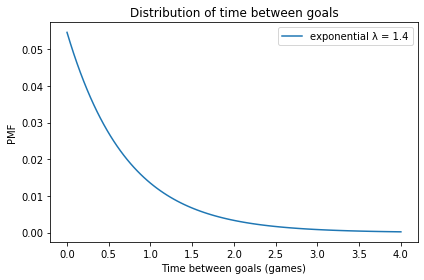

In [42]:
pmf_time.plot(label='exponential λ = 1.4')

decorate_time('Distribution of time between goals')
savefig('fig07-05')

It is counterintuitive, but true, that the most likely time to score a goal is immediately.  After that, the probability of each possible interval is a little lower.

With a goal-scoring rate of 1.4, it is possible that a team will take more than one game to score a goal, but it is unlikely that they will take more than two games.

## Exercises

**Exercise:** Finish off the exercise from the previous section.  Here are the steps I recommend:

1. Starting with the same gamma prior we used in the previous problem, compute the likelihood of scoring a goal after 11 minutes for each possible value of `λ`.  Don't forget to convert all times into units of games.

2. Use `bayes_update` to compute the posterior distribution of `λ` for Germany after the first goal.  If the total probability of the data is greater than 1, don't panic; because the likelihoods are not probabilities, the return value from `bayes_update` is not a probability either.  But the posterior distribution is still valid.

3. Compute the likelihood of scoring another goal after 12 more minutes and do another update.  Plot the prior, posterior after one goal, and posterior after two goals.

4. Compute the posterior predictive distribution of goals Germany might score during the remaining time in the game, `90-23` minutes.  Note: you will have to think about how to generate predicted goals for a fraction of a game.

6. Compute the probability of scoring 5 goals during the remaining time.

In [43]:
# Solution

def update_time(pmf, data):
    """Update based on an observed interval
    
    pmf: prior PMF
    data: time between goals in minutes
    """
    t = data / 90
    λs = pmf.qs
    likelihood = expo_pdf(t, λs)
    pmf *= likelihood
    pmf.normalize()

In [44]:
# Solution

germany = prior.copy()
update_time(germany, 11)

germany2 = germany.copy()
update_time(germany2, 12)

In [45]:
# Solution

germany.mean(), germany2.mean()

(2.1358882653086892, 2.703059034926364)

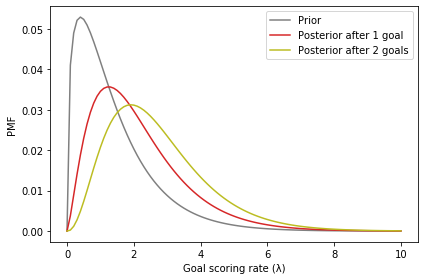

In [46]:
# Solution

prior.plot(color='gray', label='Prior')
germany.plot(color='C3', label='Posterior after 1 goal')
germany2.plot(color='C8', label='Posterior after 2 goals')

decorate_rate()

In [47]:
# Solution

t = (90-23) / 90

pmf_seq = [make_poisson_pmf(λ*t, 12) 
           for λ in germany.qs]

In [48]:
# Solution

pmf_germany = make_mixture(germany, pmf_seq)

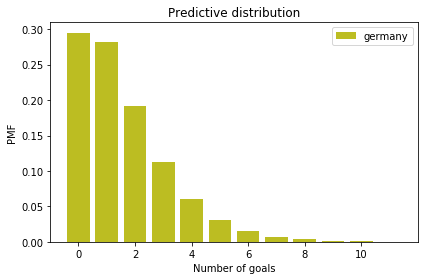

In [49]:
# Solution

pmf_germany.bar(color='C8', label='germany')
decorate_goals('Predictive distribution')

In [50]:
pmf_germany[5]

0.03077879173047912

In [51]:
pmf_germany.prob_ge(5)

0.05901147597181205

**Exercise:** Returning to the first version of the World Cup Problem.  Suppose France and Croatia play a rematch.  What is the probability that France scores first?

Hint: You can compute the posterior predictive probability for the time until the first goal by making a mixture of exponential distributions.  You can use the following function to make a PMF that approximates an exponential distribution.

In [52]:
def make_expo_pmf(λ, high):
    """Make a PMF of an exponential distribution.
    
    λ: event rate
    high: upper bound on the interval `t`
    
    returns: Pmf of the interval between events
    """
    qs = np.linspace(0, high, 101)
    ps = expo_pdf(qs, λ)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [53]:
# Solution

pmf_seq = [make_expo_pmf(λ*t, 4) for λ in prior.qs]

In [54]:
# Solution

pred_france = make_mixture(france, pmf_seq)
pred_croatia = make_mixture(croatia, pmf_seq)

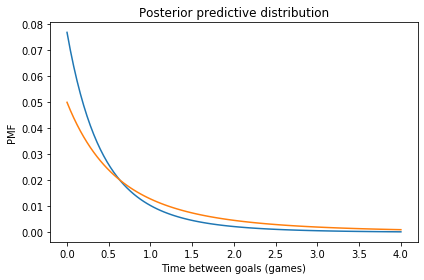

In [55]:
# Solution

pred_france.plot()
pred_croatia.plot()

decorate_time('Posterior predictive distribution')

In [56]:
# Solution

Pmf.prob_lt(pred_france, pred_croatia)

0.5908529385949816

**Exercise:** In the 2010-11 National Hockey League (NHL) Finals, my beloved Boston
Bruins played a best-of-seven championship series against the despised
Vancouver Canucks.  Boston lost the first two games 0-1 and 2-3, then
won the next two games 8-1 and 4-0.  At this point in the series, what
is the probability that Boston will win the next game, and what is
their probability of winning the championship?

To choose a prior distribution, I got some statistics from
http://www.nhl.com, specifically the average goals per game
for each team in the 2010-11 season.  The distribution well modeled by a gamma distribution with mean 2.8.

In [57]:
# Solution

from scipy.stats import gamma

α = 2.8
qs = np.linspace(0, 15, 101)
ps = gamma.pdf(qs, α)
prior = Pmf(ps, qs)
prior.normalize()

6.666325137469514

2.7997400090376567

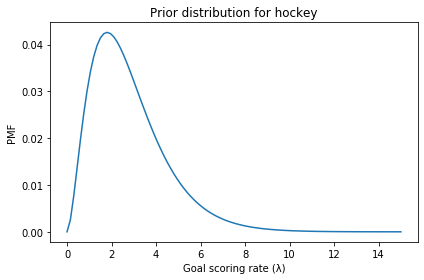

In [58]:
# Solution

prior.plot()
decorate_rate('Prior distribution for hockey')
prior.mean()

In [59]:
# Solution

bruins = prior.copy()
for data in [0, 2, 8, 4]:
    update_poisson(bruins, data)
    
bruins.mean()

3.3599999999999985

In [60]:
# Solution

canucks = prior.copy()
for data in [1, 3, 1, 0]:
    update_poisson(canucks, data)
    
canucks.mean()

1.5599999606443666

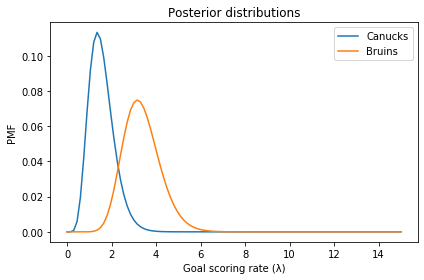

In [61]:
# Solution

canucks.plot(label='Canucks')
bruins.plot(label='Bruins')

decorate_rate('Posterior distributions')

In [62]:
# Solution

pmf_seq = [make_poisson_pmf(λ, 15) for λ in prior.qs]

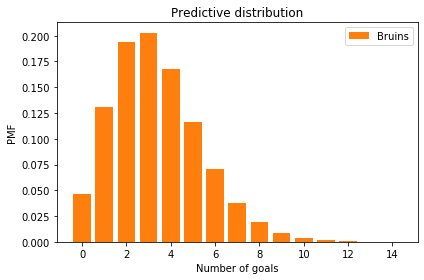

In [63]:
# Solution

pred_bruins = make_mixture(bruins, pmf_seq)

pred_bruins.bar(label='Bruins', color='C1')
decorate_goals('Predictive distribution')

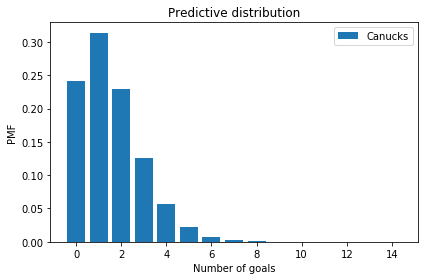

In [64]:
# Solution

pred_canucks = make_mixture(canucks, pmf_seq)

pred_canucks.bar(label='Canucks')
decorate_goals('Predictive distribution')

In [65]:
# Solution

win = Pmf.prob_gt(pred_bruins, pred_canucks)
lose = Pmf.prob_lt(pred_bruins, pred_canucks)
tie = Pmf.prob_eq(pred_bruins, pred_canucks)

win, lose, tie

(0.7038631514645926, 0.16111690750716465, 0.1350199410282429)

In [66]:
# Solution

# Assuming the Bruins win half of the ties,
# their chance of winning the next game is...

p = win + lose/2
p

0.7844216052181748

In [67]:
# Solution

# Their chance of winning the series is their
# chance of winning k=2 or k=3 of the remaining
# n=3 games.

from scipy.stats import binom

n = 3
a = binom.pmf([2,3], n, p)
a.sum()

0.8806154668468822